In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "RAV"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn107011,MSVEAAAGLRGDEHTEKTLGPRLFRHQEMDGRSTDESTTSTDSLSI...,349,1
1,Achn170441,MESSCIDESTTSDLLSFSPARTPPATVKSPPESLCRMGSGTSVVLD...,361,1
2,Achn251751,MESCCIDESTTSDLLSFSPARTPPATVKSPPESLCRMGSGTSVVLD...,361,1
3,Achn252961,MEEEPSSMIEDVKTRVITEDSVSSSPCQPSNAGMHPIKDNKAMSSK...,352,1
4,Achn261561,MIEDVKTHVIAEGSVSSSPCQPSNAAMPAKFKGVVPQPNGHWGAQI...,303,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
1254,0.015625,0.000000,0.001736,0.003472,0.001736,0.003472,0.000000,0.001736,0.001736,0.001736,...,0.001736,0.001736,0.001736,0.003472,0.000000,0.0,0.000000,0.000000,0.0,0.001736
770,0.000000,0.005618,0.000000,0.000000,0.000000,0.011236,0.000000,0.000000,0.000000,0.005618,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
1056,0.029536,0.000000,0.012658,0.008439,0.000000,0.000000,0.004219,0.008439,0.004219,0.008439,...,0.000000,0.000000,0.000000,0.000000,0.004219,0.0,0.000000,0.000000,0.0,0.000000
730,0.002315,0.004630,0.002315,0.004630,0.000000,0.002315,0.000000,0.000000,0.009259,0.004630,...,0.002315,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
456,0.005435,0.002717,0.000000,0.013587,0.005435,0.002717,0.000000,0.000000,0.000000,0.002717,...,0.000000,0.000000,0.000000,0.000000,0.002717,0.0,0.002717,0.002717,0.0,0.000000


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (1086, 440)
X_test: (272, 440)
y_train: (1086,)
y_test: (272,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         112,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,161 (610.00 KB)

 Trainable params: 156,161 (610.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 12s 994ms/step - accuracy: 0.5469 - loss: 0.6930

 4/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5124 - loss: 0.6928  

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5463 - loss: 0.6902 - val_accuracy: 0.7064 - val_loss: 0.6675


Epoch 2/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6094 - loss: 0.6732

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8378 - loss: 0.6483 - val_accuracy: 0.9128 - val_loss: 0.5335


Epoch 3/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8750 - loss: 0.5673

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9450 - loss: 0.4759 - val_accuracy: 0.9679 - val_loss: 0.2291


Epoch 4/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.2188

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9760 - loss: 0.1740 - val_accuracy: 0.9725 - val_loss: 0.0791


Epoch 5/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9531 - loss: 0.1235

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9762 - loss: 0.0736 - val_accuracy: 0.9725 - val_loss: 0.0706


Epoch 6/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0135

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9876 - loss: 0.0386 - val_accuracy: 0.9771 - val_loss: 0.0576


Epoch 7/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0080

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9931 - loss: 0.0240 - val_accuracy: 0.9771 - val_loss: 0.0613


Epoch 8/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9844 - loss: 0.0348

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9910 - loss: 0.0242 - val_accuracy: 0.9771 - val_loss: 0.0535


Epoch 9/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9844 - loss: 0.0125

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9904 - loss: 0.0191 - val_accuracy: 0.9771 - val_loss: 0.0546


Epoch 10/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9844 - loss: 0.0554

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9947 - loss: 0.0178 - val_accuracy: 0.9771 - val_loss: 0.0549


Epoch 11/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0035

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9976 - loss: 0.0113 - val_accuracy: 0.9817 - val_loss: 0.0619


Epoch 12/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0094

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9954 - loss: 0.0147 - val_accuracy: 0.9725 - val_loss: 0.0610


Epoch 13/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0019

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0.9771 - val_loss: 0.0616


Epoch 14/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0016

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9989 - loss: 0.0059 - val_accuracy: 0.9725 - val_loss: 0.0628


Epoch 15/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 4.9438e-04

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9932 - loss: 0.0160 - val_accuracy: 0.9725 - val_loss: 0.1068


Epoch 16/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9844 - loss: 0.0370

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9910 - loss: 0.0248 - val_accuracy: 0.9725 - val_loss: 0.0701


Epoch 17/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 4.8302e-04

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9966 - loss: 0.0063 - val_accuracy: 0.9725 - val_loss: 0.0940


Epoch 18/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0059

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0053 - val_accuracy: 0.9771 - val_loss: 0.0646


Epoch 19/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 7.1259e-04

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9984 - loss: 0.0050 - val_accuracy: 0.9771 - val_loss: 0.0996


Epoch 20/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.5970e-04

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9987 - loss: 0.0086 - val_accuracy: 0.9771 - val_loss: 0.0866


Epoch 21/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 5.1692e-04

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9963 - loss: 0.0148 - val_accuracy: 0.9679 - val_loss: 0.1202



[Train Accuracy: 99.77% - Test Accuracy: 95.59%]


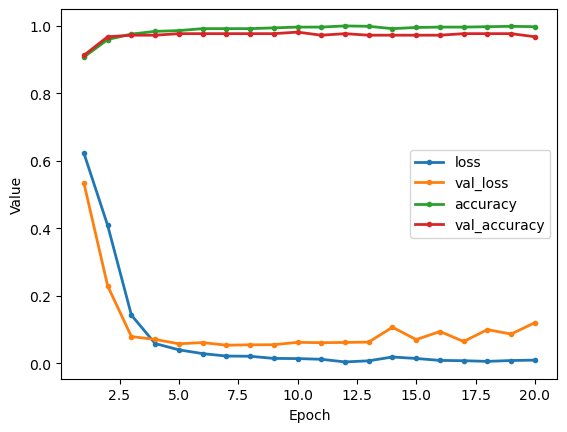

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYM,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYX,YYY
1254,0.001739,0.0,0.0,0.000000,0.0,0.001739,0.000000,0.000000,0.001739,0.0,...,0.0,0.0,0.0,0.0,0.001739,0.0,0.0,0.0,0.0,0.0
770,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1056,0.008475,0.0,0.0,0.008475,0.0,0.000000,0.004237,0.004237,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
730,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
456,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (1086, 8374)
X_test: (272, 8374)
y_train: (1086,)
y_test: (272,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,144,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,187,265 (8.34 MB)

 Trainable params: 2,187,265 (8.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4219 - loss: 0.6932

 5/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4797 - loss: 0.6930

 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5573 - loss: 0.6923

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6182 - loss: 0.6911

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6410 - loss: 0.6904 - val_accuracy: 0.9587 - val_loss: 0.6623


Epoch 2/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9688 - loss: 0.6612

 5/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9734 - loss: 0.6561

 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9754 - loss: 0.6484

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9759 - loss: 0.6392

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9762 - loss: 0.6346 - val_accuracy: 0.9587 - val_loss: 0.4894


Epoch 3/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9844 - loss: 0.4834

 5/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9866 - loss: 0.4613

 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9873 - loss: 0.4340

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9869 - loss: 0.4065

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9863 - loss: 0.3951 - val_accuracy: 0.9862 - val_loss: 0.1366


Epoch 4/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 0.1171

 5/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9947 - loss: 0.1078

 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9934 - loss: 0.0965

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9920 - loss: 0.0896

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9915 - loss: 0.0867 - val_accuracy: 0.9908 - val_loss: 0.0362


Epoch 5/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9844 - loss: 0.0232

 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9902 - loss: 0.0241 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9918 - loss: 0.0228 - val_accuracy: 0.9908 - val_loss: 0.0216


Epoch 6/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0063

 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0056 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9988 - loss: 0.0065 - val_accuracy: 0.9954 - val_loss: 0.0170


Epoch 7/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 0.0046

 4/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0047

 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0052

12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0048

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.9954 - val_loss: 0.0184


Epoch 8/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 8.2745e-04

 5/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0010    

 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0017

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0020

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9954 - val_loss: 0.0137


Epoch 9/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 0.0020

 5/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0018 

 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0017

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0016

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9954 - val_loss: 0.0175


Epoch 10/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 9.0152e-04

 5/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 8.6793e-04

 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 8.3822e-04

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 8.2140e-04

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 8.7017e-04 - val_accuracy: 0.9954 - val_loss: 0.0179


Epoch 11/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.3098e-04

 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.9083e-04 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9954 - val_loss: 0.0130


Epoch 12/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 6.2366e-04

 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.8218e-04 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 8.1452e-04 - val_accuracy: 0.9954 - val_loss: 0.0153


Epoch 13/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 4.5254e-04

 5/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 4.4373e-04

 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 4.2326e-04

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 4.2291e-04

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 4.3188e-04 - val_accuracy: 0.9954 - val_loss: 0.0162


Epoch 14/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 2.9487e-04

 5/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 6.3888e-04

 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 6.2840e-04

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 5.9945e-04

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 5.9505e-04 - val_accuracy: 0.9954 - val_loss: 0.0143


Epoch 15/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 4.1205e-04

 5/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 4.1260e-04

 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 4.6983e-04

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 4.8717e-04

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 4.9053e-04 - val_accuracy: 0.9954 - val_loss: 0.0165


Epoch 16/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 2.1094e-04

 5/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 2.4548e-04

 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 2.6383e-04

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 2.8357e-04

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 2.8719e-04 - val_accuracy: 0.9954 - val_loss: 0.0188



[Train Accuracy: 100.00% - Test Accuracy: 99.26%]


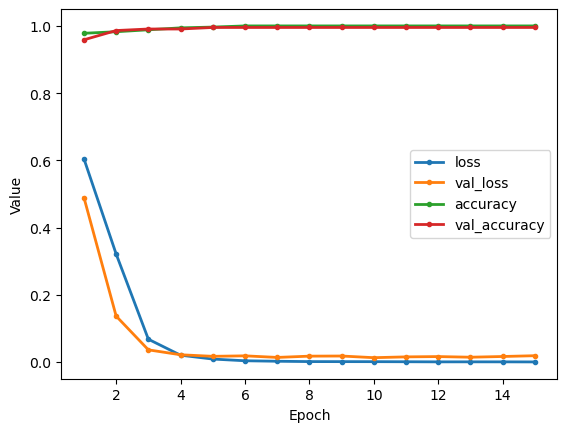

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYH,YYYL,YYYM,YYYN,YYYQ,YYYR,YYYS,YYYT,YYYX,YYYY
1254,0.0,0.0,0.0,0.000000,0.0,0.001742,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
770,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1056,0.0,0.0,0.0,0.004255,0.0,0.000000,0.004255,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
730,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
456,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      26,496,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,537,473 (101.23 MB)

 Trainable params: 26,537,473 (101.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5000 - loss: 0.6932

 2/14 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.4922 - loss: 0.6931

 3/14 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.5122 - loss: 0.6931

 4/14 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.5267 - loss: 0.6930

 5/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5389 - loss: 0.6929 

 6/14 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5536 - loss: 0.6927

 7/14 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5677 - loss: 0.6926

 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5819 - loss: 0.6924

 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5952 - loss: 0.6921

10/14 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6069 - loss: 0.6919

11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6182 - loss: 0.6916

12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6290 - loss: 0.6913

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6386 - loss: 0.6910

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.6475 - loss: 0.6907

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.6553 - loss: 0.6904 - val_accuracy: 0.9725 - val_loss: 0.6653


Epoch 2/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.9844 - loss: 0.6659

 2/14 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9609 - loss: 0.6656 

 3/14 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9601 - loss: 0.6640

 4/14 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9603 - loss: 0.6623

 5/14 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9595 - loss: 0.6607

 6/14 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9602 - loss: 0.6591

 7/14 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9611 - loss: 0.6574

 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9618 - loss: 0.6557

 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9627 - loss: 0.6538

10/14 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9635 - loss: 0.6518

11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9642 - loss: 0.6498

12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9650 - loss: 0.6477

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9658 - loss: 0.6454

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9665 - loss: 0.6433

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9671 - loss: 0.6414 - val_accuracy: 0.9725 - val_loss: 0.5246


Epoch 3/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9688 - loss: 0.5166

 2/14 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9648 - loss: 0.5120 

 3/14 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9644 - loss: 0.5065

 4/14 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9665 - loss: 0.5002

 5/14 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9676 - loss: 0.4946

 6/14 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9686 - loss: 0.4887

 7/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9699 - loss: 0.4829

 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9703 - loss: 0.4779

 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9709 - loss: 0.4728

10/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9714 - loss: 0.4676

11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9721 - loss: 0.4623

12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9728 - loss: 0.4569

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9734 - loss: 0.4516

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9740 - loss: 0.4466

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.9745 - loss: 0.4421 - val_accuracy: 0.9862 - val_loss: 0.2263


Epoch 4/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9844 - loss: 0.2065

 2/14 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9844 - loss: 0.1975 

 3/14 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9861 - loss: 0.1899

 4/14 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9857 - loss: 0.1862

 5/14 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9860 - loss: 0.1813

 6/14 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9862 - loss: 0.1764

 7/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9863 - loss: 0.1720

 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9865 - loss: 0.1678

 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9869 - loss: 0.1638

10/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9871 - loss: 0.1599

11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9872 - loss: 0.1563

12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9874 - loss: 0.1527

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9876 - loss: 0.1493

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9879 - loss: 0.1463

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9881 - loss: 0.1436 - val_accuracy: 0.9954 - val_loss: 0.0582


Epoch 5/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 1.0000 - loss: 0.0227

 2/14 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 1.0000 - loss: 0.0254 

 3/14 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9983 - loss: 0.0276

 4/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9977 - loss: 0.0282

 5/14 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9976 - loss: 0.0282

 6/14 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9975 - loss: 0.0277

 7/14 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9972 - loss: 0.0274

 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9971 - loss: 0.0269

 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9970 - loss: 0.0264

10/14 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9969 - loss: 0.0261

11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9968 - loss: 0.0257

12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9967 - loss: 0.0253 

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9967 - loss: 0.0249

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9967 - loss: 0.0245

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9967 - loss: 0.0242 - val_accuracy: 0.9954 - val_loss: 0.0316


Epoch 6/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 0.0076

 2/14 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 1.0000 - loss: 0.0070 

 3/14 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 1.0000 - loss: 0.0067

 4/14 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 0.0065

 5/14 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 1.0000 - loss: 0.0064

 6/14 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 0.0063

 7/14 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 1.0000 - loss: 0.0062

 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 0.0061

 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 0.0061

10/14 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 0.0061

11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 0.0060

12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 0.0060

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 0.0059

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 0.0058 

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 0.0058 - val_accuracy: 0.9954 - val_loss: 0.0234


Epoch 7/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 0.0040

 2/14 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 1.0000 - loss: 0.0035 

 3/14 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 1.0000 - loss: 0.0035

 4/14 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 0.0034

 5/14 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 0.0032

 6/14 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 0.0031

 7/14 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 0.0030

 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 1.0000 - loss: 0.0030

 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 1.0000 - loss: 0.0029

10/14 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 1.0000 - loss: 0.0028

11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 0.0028

12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 0.0028

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 0.0028

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 1.0000 - loss: 0.0027

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.9954 - val_loss: 0.0218


Epoch 8/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 0.0019

 2/14 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 1.0000 - loss: 0.0018 

 3/14 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 1.0000 - loss: 0.0018

 4/14 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 1.0000 - loss: 0.0018

 5/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 0.0018

 6/14 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 1.0000 - loss: 0.0017

 7/14 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 1.0000 - loss: 0.0017

 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 1.0000 - loss: 0.0017

 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 1.0000 - loss: 0.0016

10/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 0.0016

11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 0.0016

12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 0.0016

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 1.0000 - loss: 0.0016

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 1.0000 - loss: 0.0016

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9954 - val_loss: 0.0216


Epoch 9/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 7.0240e-04

 2/14 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 1.0000 - loss: 6.7189e-04 

 3/14 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 6.4908e-04

 4/14 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 6.8599e-04

 5/14 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 1.0000 - loss: 7.1120e-04

 6/14 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 1.0000 - loss: 7.3861e-04

 7/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 7.5738e-04

 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 7.7900e-04

 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 1.0000 - loss: 7.9126e-04

10/14 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 1.0000 - loss: 8.0039e-04

11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 1.0000 - loss: 8.0566e-04

12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 1.0000 - loss: 8.1637e-04

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 1.0000 - loss: 8.2299e-04

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 1.0000 - loss: 8.2909e-04

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 1.0000 - loss: 8.3437e-04 - val_accuracy: 0.9954 - val_loss: 0.0222


Epoch 10/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 6.5926e-04

 2/14 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 1.0000 - loss: 6.2082e-04

 3/14 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 1.0000 - loss: 6.3126e-04

 4/14 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 1.0000 - loss: 6.6702e-04 

 5/14 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 6.7754e-04

 6/14 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 7.2831e-04

 7/14 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 7.5687e-04

 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 1.0000 - loss: 7.7337e-04

 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 1.0000 - loss: 7.8231e-04

10/14 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 1.0000 - loss: 7.8555e-04

11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 1.0000 - loss: 7.8725e-04

12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 7.8706e-04

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 1.0000 - loss: 7.8486e-04

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 1.0000 - loss: 7.9640e-04

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 8.0639e-04 - val_accuracy: 0.9954 - val_loss: 0.0211


Epoch 11/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 8.6029e-04

 2/14 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 8.7404e-04

 3/14 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 8.3649e-04

 4/14 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 1.0000 - loss: 8.2735e-04

 5/14 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 8.1114e-04

 6/14 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 1.0000 - loss: 7.9178e-04

 7/14 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 1.0000 - loss: 7.7335e-04

 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 7.5739e-04

 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 1.0000 - loss: 7.4797e-04

10/14 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 1.0000 - loss: 7.3845e-04

11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 1.0000 - loss: 7.3207e-04

12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 1.0000 - loss: 7.2799e-04

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 1.0000 - loss: 7.2354e-04

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 7.2229e-04

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 7.2120e-04 - val_accuracy: 0.9954 - val_loss: 0.0203


Epoch 12/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 6.5046e-04

 2/14 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 1.0000 - loss: 6.0043e-04 

 3/14 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 5.7511e-04

 4/14 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 5.5683e-04

 5/14 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 5.5682e-04

 6/14 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 5.5668e-04

 7/14 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 5.5498e-04

 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 5.8950e-04

 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 6.1373e-04 

10/14 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 1.0000 - loss: 6.3379e-04

11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 1.0000 - loss: 6.4632e-04

12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 1.0000 - loss: 6.5394e-04

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 1.0000 - loss: 6.5759e-04

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 1.0000 - loss: 6.5944e-04

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 6.6105e-04 - val_accuracy: 0.9954 - val_loss: 0.0203


Epoch 13/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 5.0505e-04

 2/14 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 1.0000 - loss: 4.7042e-04

 3/14 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 1.0000 - loss: 7.1446e-04

 4/14 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 7.9002e-04 

 5/14 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 8.0790e-04

 6/14 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 8.2107e-04

 7/14 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 8.1817e-04

 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 8.0921e-04

 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 7.9807e-04

10/14 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 7.8520e-04

11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 7.7412e-04

12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 7.6248e-04

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 7.5092e-04

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 1.0000 - loss: 7.4006e-04

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 7.3064e-04 - val_accuracy: 0.9954 - val_loss: 0.0199


Epoch 14/100


 1/14 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 1.0000 - loss: 2.6095e-04

 2/14 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 1.0000 - loss: 3.2710e-04 

 3/14 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 1.0000 - loss: 3.3936e-04

 4/14 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 1.0000 - loss: 3.3835e-04

 5/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 3.4338e-04

 6/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 3.4610e-04

 7/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 3.4767e-04

 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 3.4728e-04

 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 3.4518e-04

10/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 3.4317e-04

11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 3.4100e-04

12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 3.3988e-04

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 3.4007e-04

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 1.0000 - loss: 3.4030e-04

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 1.0000 - loss: 3.4050e-04 - val_accuracy: 0.9954 - val_loss: 0.0211



[Train Accuracy: 100.00% - Test Accuracy: 99.26%]


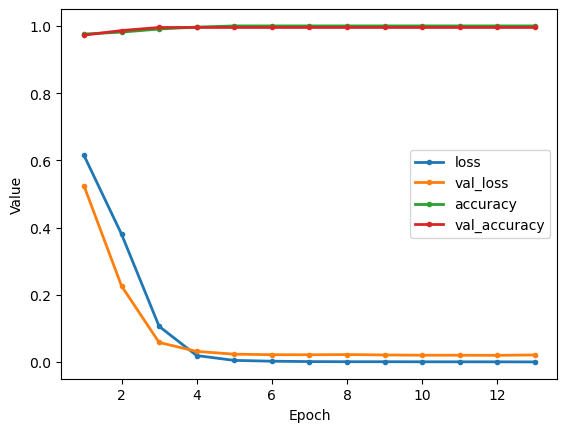

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

5/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

5/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [26]:
report.save()

Report saved as Output/Reports/RAV/report_FPZK4CL1.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################